# 0. Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from scipy.interpolate import interp1d
from scipy.stats import multivariate_normal

import torch
import gpytorch

from tqdm import tqdm
from IPython.display import clear_output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

IMG_SIZE = (50, 100)

# 1. Gaussian field

In [2]:
def min_max_normalize(x):
    return (x - x.min()) / (x.max() - x.min())

## 2D

In [4]:
points = np.moveaxis(np.indices(IMG_SIZE), 0, -1).reshape(-1, 2).astype(np.float32)

### Correlation function definition

In [3]:
def K_exp(r, a=1):
    return np.exp(-r/a)

### Stupid sampling

In [95]:
@interact(correlation_scale=(1, 10000), n=(1, 10), level=(0, 1, 0.1))
def plot_fields(correlation_scale=1000, n=5, level=0.5):
    D = np.linalg.norm(points.reshape(1, -1, 2) - points.reshape(-1, 1, 2), axis=-1)
    B = K_exp(D, a=correlation_scale)
    A = np.linalg.cholesky(B)
    fig, ax = plt.subplots(2, n, figsize=(30, 10))
    #set title
    fig.suptitle(f'$K(r) = e^{{-r/{correlation_scale}}}$')
    for i in range(n):
        normals = np.random.randn(np.prod(IMG_SIZE))
        u = (A @ normals).reshape(IMG_SIZE)
        u = (u - u.min()) / (u.max() - u.min())
        ax[0][i].imshow(u, cmap='PuOr', vmin=0, vmax=1, origin='lower')
        # ax[0][i].set_title(f'Range [{u.min():.2f}, {u.max():.2f}]')
        # plot leveel set of u
        ax[1][i].contour(u, levels=[level])

3660.37s - Error inserting pydevd breaks.
Traceback (most recent call last):
  File "c:\jupyter_workspace\_Diploma\.venv\lib\site-packages\debugpy\_vendored\pydevd\_pydevd_frame_eval\pydevd_modify_bytecode.py", line 328, in insert_pydevd_breaks
    for new_instruction in get_instructions_to_add(
  File "c:\jupyter_workspace\_Diploma\.venv\lib\site-packages\debugpy\_vendored\pydevd\_pydevd_frame_eval\pydevd_modify_bytecode.py", line 102, in get_instructions_to_add
    Instr("LOAD_CONST", _pydev_stop_at_break, lineno=stop_at_line - 1),
  File "c:\jupyter_workspace\_Diploma\.venv\lib\site-packages\debugpy\_vendored\pydevd\_pydevd_frame_eval\vendored\bytecode\instr.py", line 171, in __init__
    self._set(name, arg, lineno)
  File "c:\jupyter_workspace\_Diploma\.venv\lib\site-packages\debugpy\_vendored\pydevd\_pydevd_frame_eval\vendored\bytecode\instr.py", line 239, in _set
    _check_lineno(lineno)
  File "c:\jupyter_workspace\_Diploma\.venv\lib\site-packages\debugpy\_vendored\pydevd\_pyd

### Sampling with prior knowledge

#### Training data initialization

In [3]:
given_points = np.array([[i, j] for i in range (1, IMG_SIZE[0]) for j in range(1, IMG_SIZE[1]) if i < 5 or i >= 45])
given_values = np.zeros(len(given_points))

#### Use the training data to build and train a GPR

In [5]:


gp = GaussianProcessRegressor(RBF(4, length_scale_bounds='fixed'))
gp.fit(given_points, given_values)

predicted = gp.sample_y(points, n_samples=5).reshape(*IMG_SIZE, 5).transpose(2, 0, 1)

predicted = np.array([min_max_normalize(x) for x in predicted])

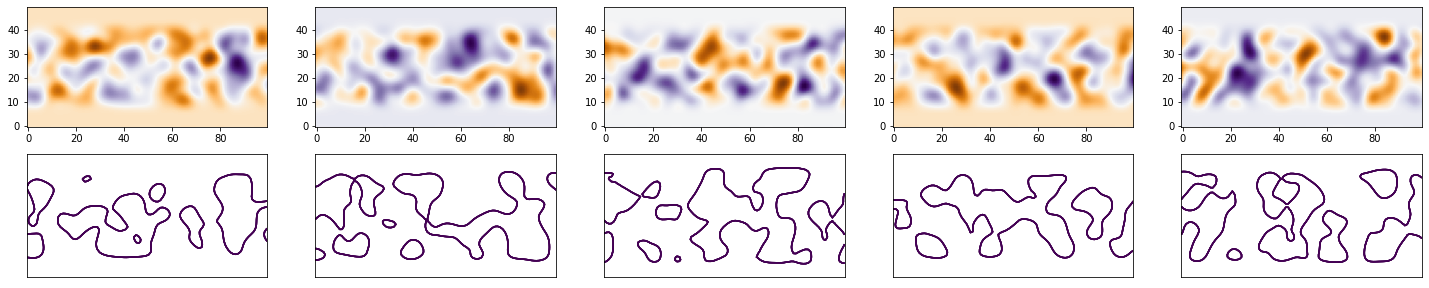

In [7]:
n=5
fig, ax = plt.subplots(2, n, figsize=(25, 5))
for i in range(n):
    for j in range(n):
        ax[0][i].imshow(predicted[i], cmap='PuOr', origin='lower')
        ax[1][i].contour(predicted[i], levels=[0.5])
        ax[1][i].get_xaxis().set_ticks([])
        ax[1][i].get_yaxis().set_ticks([])

#### Plot results

In [6]:
@interact(level=(0, 1, 0.1))    
def show_predicted(level=0.5):
    n=5
    fig, ax = plt.subplots(2, n, figsize=(25, 5))
    for i in range(n):
        for j in range(n):
            ax[0][i].imshow(predicted[i], cmap='PuOr', origin='lower')
            ax[1][i].contour(predicted[i], levels=[level])
            ax[1][i].get_xaxis().set_ticks([])
            ax[1][i].get_yaxis().set_ticks([])

interactive(children=(FloatSlider(value=0.5, description='level', max=1.0), Output()), _dom_classes=('widget-i…

## 3D

### Map 2D image to 3D cylinder

In [4]:
def min_max_normalize(x):
    return (x - x.min()) / (x.max() - x.min())

def map_to_cylinder(points):
    return np.array([np.cos(2 * np.pi * points[:, 1]), np.sin(2 * np.pi * points[:, 1]), points[:, 0]]).T

def cylinder_to_map(points):
    return np.array([np.arctan2(points[:, 1], points[:, 0]) / (2 * np.pi), points[:, 2]]).T

### Points

In [5]:
# normalize dpoints
given_points = np.array([[i, j] for i in range (0, IMG_SIZE[0]) for j in range(0, IMG_SIZE[1]) if i < 5 or i >= 45])
points = np.array([[i, j] for i in range (0, IMG_SIZE[0]) for j in range(0, IMG_SIZE[1])])
# initialize given values to random values
# given_values = np.random.randn(len(given_points))
print(given_points.shape, points.shape)

(1000, 2) (5000, 2)


In [6]:
given_points = min_max_normalize(map_to_cylinder(given_points))
points = min_max_normalize(map_to_cylinder(points))
given_values = np.zeros(len(given_points))

print(given_points.shape, points.shape, given_values.shape)

(1000, 3) (5000, 3) (1000,)


### Model

In [7]:
gp = GaussianProcessRegressor(RBF(4, length_scale_bounds='fixed'))
gp.fit(given_points, given_values)

GaussianProcessRegressor(kernel=RBF(length_scale=4))

In [8]:
n_samples = 5


predicted = gp.sample_y(points, n_samples=n_samples)

In [9]:
predicted = predicted.reshape(*IMG_SIZE, n_samples).transpose(2, 0, 1)
predicted = np.array([min_max_normalize(x) for x in predicted])

In [10]:
predicted.shape

(5, 50, 100)

### Plot

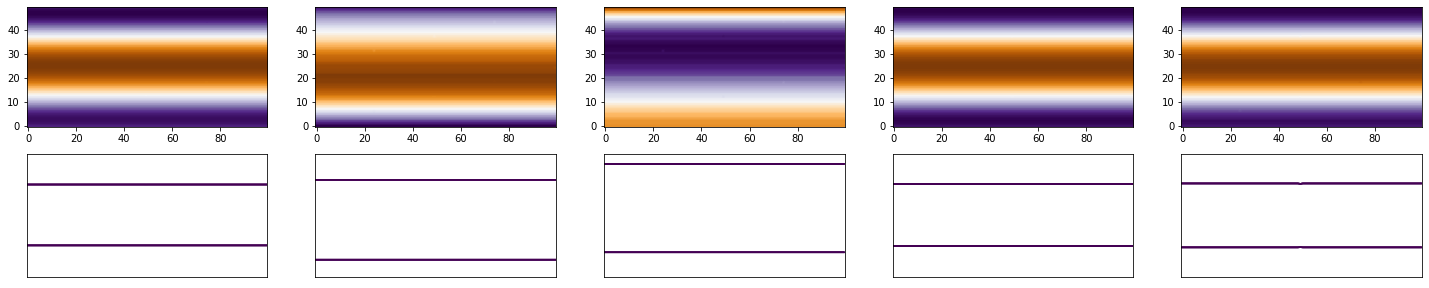

In [11]:
n=n_samples
fig, ax = plt.subplots(2, n, figsize=(25, 5))
for i in range(n):
    for j in range(n):
        ax[0][i].imshow(predicted[i], cmap='PuOr', origin='lower')
        ax[1][i].contour(predicted[i], levels=[0.5])
        ax[1][i].get_xaxis().set_ticks([])
        ax[1][i].get_yaxis().set_ticks([])

### Other

In [16]:
import plotly.express as px
cyl_points = map_to_cylinder(points)
fig = px.scatter_3d(cyl_points, x=0, y=1, z=2, opacity=0.5)
fig.show()

In [13]:
cyl_points[:, 0] *= IMG_SIZE[0] / (2 * np.pi)
cyl_points[:, 1] *= IMG_SIZE[0] / (2 * np.pi)
cyl_points[:, 2] *= IMG_SIZE[1]

fig = px.scatter_3d(cyl_points, x=0, y=1, z=2, opacity=0.5)
fig.show()

In [17]:
cyl_points[:, 2]

array([  0.,   0.,   0., ..., 100., 100., 100.], dtype=float32)

In [15]:
fig = px.scatter_3d(cyl_points[cyl_points[:, 2] > 95], x=0, y=1, z=2, opacity=0.5)
fig.show()


In [20]:
px.scatter(points, x=0, y=1, opacity=0.5)

In [34]:
points[:, 0] /= (IMG_SIZE[0] - 1)
points[:, 1] /= (IMG_SIZE[1] - 1)
points

array([[0.        , 0.        ],
       [0.        , 0.01010101],
       [0.        , 0.02020202],
       ...,
       [1.        , 0.97979796],
       [1.        , 0.989899  ],
       [1.        , 1.        ]], dtype=float32)

In [42]:
# Create a new array of points on the cylinder surface
cyl_points = np.array([np.cos(2 * np.pi * points[:, 1]), np.sin(2 * np.pi * points[:, 1]), points[:, 0]]).T
cyl_points[:, 0] *= IMG_SIZE[0] / (2 * np.pi)
cyl_points[:, 1] *= IMG_SIZE[0] / (2 * np.pi)
cyl_points[:, 2] *= IMG_SIZE[1]

fig = px.scatter_3d(cyl_points, x=0, y=1, z=2, opacity=0.5)
fig.show()

array([  0.,   0.,   0., ..., 100., 100., 100.], dtype=float32)

In [49]:
given_points = cyl_points[cyl_points[:, 2] > 95]
given_values = np.zeros(len(given_points))

px.scatter(given_points, x=0, y=1, opacity=0.5)

In [58]:
gp = GaussianProcessRegressor(RBF())
gp.fit(given_points, given_values)
predicted = gp.sample_y(map_to_cylinder(points), n_samples=5)

In [59]:
print(f'predicted.shape = {predicted.shape},\ngiven_points.shape = {given_points.shape}\n given_values.shape = {given_values.shape}')

predicted.shape = (2500, 5),
given_points.shape = (25000, 3)
 given_values.shape = (25000,)


In [23]:
predicted = predicted.reshape(*IMG_SIZE, 5).transpose(2, 0, 1)
predicted

array([[[0.41918803, 0.41701844, 0.41861733, ..., 0.41707198,
         0.41707026, 0.41707063],
        [0.42063209, 0.41896782, 0.41737015, ..., 0.49124539,
         0.449143  , 0.39052854],
        [0.62350802, 0.6018642 , 0.36218609, ..., 0.64603009,
         0.47869534, 0.33082207],
        ...,
        [0.30229873, 0.55464976, 0.52353115, ..., 0.18047501,
         0.57439161, 0.47100898],
        [0.43150003, 0.48903516, 0.49104976, ..., 0.53191835,
         0.53614656, 0.53621616],
        [0.53566059, 0.53574116, 0.53574492, ..., 0.53574303,
         0.53574146, 0.53574012]],

       [[0.4189265 , 0.41662077, 0.41912381, ..., 0.41707098,
         0.41706998, 0.41707141],
        [0.42037038, 0.41803797, 0.41790674, ..., 0.49587487,
         0.43841675, 0.3779366 ],
        [0.63973764, 0.54264936, 0.35964776, ..., 0.63798066,
         0.42297368, 0.35509823],
        ...,
        [0.34894127, 0.56707994, 0.51321613, ..., 0.24972547,
         0.59682463, 0.43920009],
        [0.4

In [68]:
predicted.shape

(5, 50, 50)

In [10]:
@interact(level=(0, 1, 0.1))    
def show_predicted(level=0.5, n=5):
    fig, ax = plt.subplots(1, n, figsize=(10, 10))
    for i in range(n):

        ax[i].imshow(predicted[i], vmin=0, vmax=1, cmap='PuOr', origin='lower')
        # ax[i][j].contour(predicted[i], levels=[level])
        # ax[i][j].get_xaxis().set_ticks([])
        # ax[i][j].get_yaxis().set_ticks([])

interactive(children=(FloatSlider(value=0.5, description='level', max=1.0), IntSlider(value=5, description='n'…

# 2. GP tutorial

https://cosmiccoding.com.au/tutorials/gaussian_processes

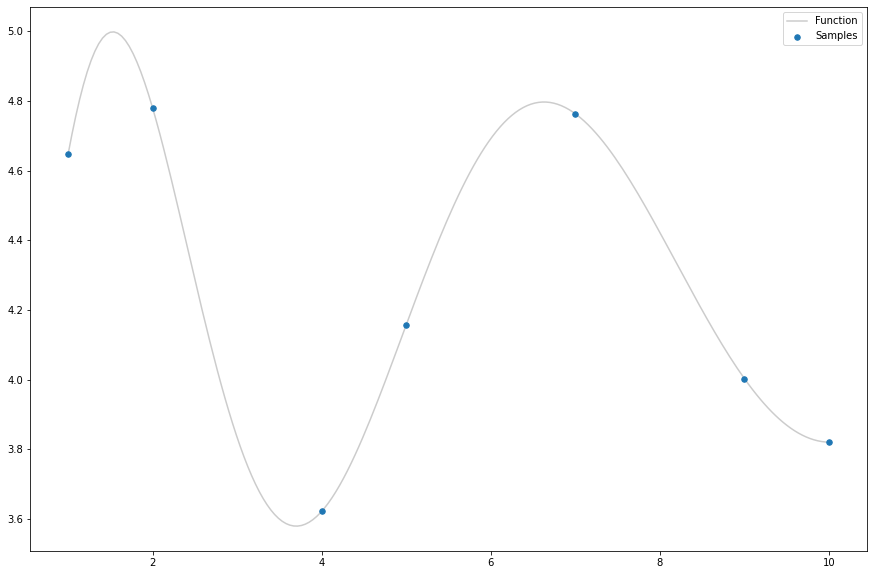

In [21]:
# Our funky function here
def fn(xs):
    return np.exp((xs + 10.5)**0.1) + np.sin(xs) / (xs + 1) + np.cos(2.5 * xs**0.5)**2

# Lets generate both the good visualisation of the function and some samples
xs = np.array([1, 2, 4, 5, 7, 9, 10])
x_fine = np.linspace(1, 10, 200)
ys, y_fine = fn(xs), fn(x_fine)

# And plot it out
plt.figure(figsize=(15, 10))
plt.plot(x_fine, y_fine, c="#ccc", label="Function")
plt.scatter(xs, ys, s=30, label="Samples", zorder=20)
plt.legend()

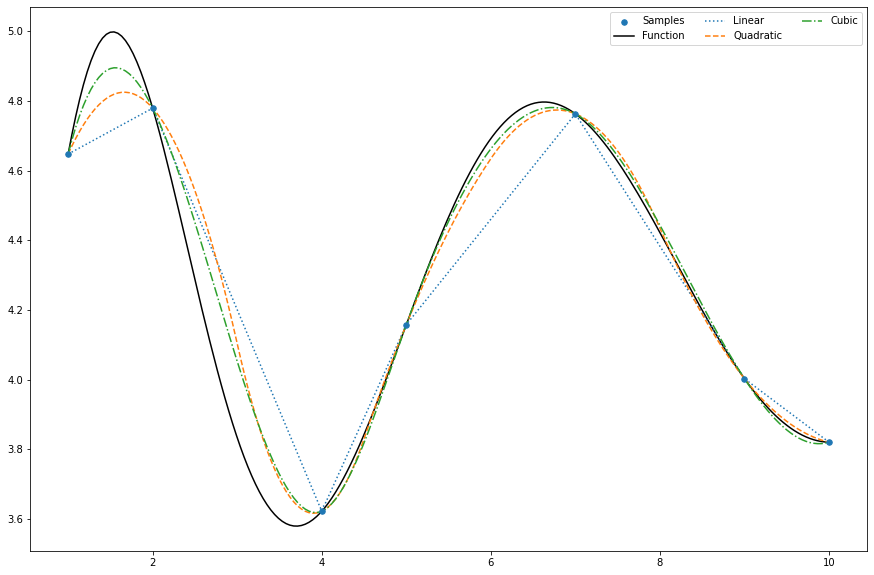

In [3]:
y_linear = interp1d(xs, ys, kind="linear")(x_fine)
y_quad = interp1d(xs, ys, kind="quadratic")(x_fine)
y_cubic = interp1d(xs, ys, kind="cubic")(x_fine)

plt.figure(figsize=(15, 10))
plt.scatter(xs, ys, s=30, zorder=20, label="Samples")
plt.plot(x_fine, y_fine, label="Function", color="k")
plt.plot(x_fine, y_linear, label="Linear", linestyle='dotted')
plt.plot(x_fine, y_quad, label="Quadratic", linestyle='--')
plt.plot(x_fine, y_cubic, label="Cubic", linestyle='dashdot')
plt.legend(ncol=3)

In [4]:
def get_cov(size=20, length=50):    
    x = np.arange(size)
    cov = np.exp(-(1 / length) * (x - np.atleast_2d(x).T)**2)
    return cov

# cov = get_cov()
# cov2 = get_cov(length=5)

# fig, axes = plt.subplots(ncols=2, figsize=(15, 10))
# axes[0].imshow(cov2, cmap="PuOr")
# axes[0].set_title("Small correlation length", fontsize=14)
# # add a colorbar
# fig.colorbar(axes[0].imshow(cov2, cmap="PuOr"), ax=axes[0])
# axes[1].set_title("Large correlation length", fontsize=14)
# axes[1].imshow(cov, cmap="PuOr")

@interact(size=(1, 100, 1), length=(1, 100, 1))
def show_cov(size=20, length=50):
    cov = get_cov(size, length)
    plt.figure(figsize=(15, 10))
    plt.imshow(cov, cmap="PuOr")
    plt.title(f"Correlation length: {length}, size: {size}", fontsize=14)
    plt.colorbar()

interactive(children=(IntSlider(value=20, description='size', min=1), IntSlider(value=50, description='length'…

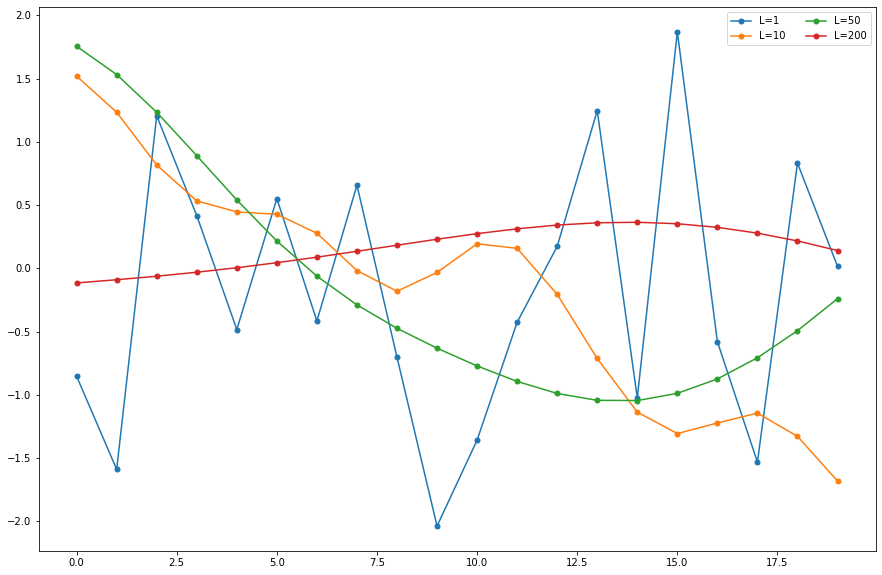

In [5]:
x = np.arange(20)
plt.figure(figsize=(15, 10))
for l in [1, 10, 50, 200]:
    cov = get_cov(size=len(x), length=l)
    rvs = multivariate_normal.rvs(cov=cov)
    plt.plot(x, rvs, 'o-', ms=5, label=f"L={l}")
plt.legend(ncol=2)

In [6]:
import matplotlib.gridspec as gridspec

In [18]:
@interact(size=(1, 100, 1), x=(20, 100))
def show_cov(size=20, x=20):
    # cov = get_cov(size, length)
    # plt.figure(figsize=(15, 10))
    # rvs = multivariate_normal.rvs(cov=cov)
    # for l in [1, 10, 50, 200]:
    #     cov = get_cov(size=len(x), length=l)
    #     rvs = multivariate_normal.rvs(cov=cov)
    #     plt.plot(x, rvs, 'o-', ms=5, label=f"L={l}")
    # plt.legend(ncol=2)
    x = np.arange(x)
    fig = plt.figure(figsize=(25, 15))
    gs = gridspec.GridSpec(4, 8)
    graph_axes = plt.subplot(gs[:, :4])
    for i, l in enumerate([1, 10, 50, 200]):
        ax = plt.subplot(gs[i // 2, 4 + i % 2])
        cov = get_cov(size=len(x), length=l)
        rvs = multivariate_normal.rvs(cov=cov)
        ax.imshow(cov, cmap="PuOr")
        ax.set_title(f'Covarience matrix with length={l}')
        graph_axes.plot(x, rvs, 'o-', ms=5, label=f"L={l}")
    graph_axes.legend(ncol=2)

interactive(children=(IntSlider(value=20, description='size', min=1), IntSlider(value=20, description='x', min…

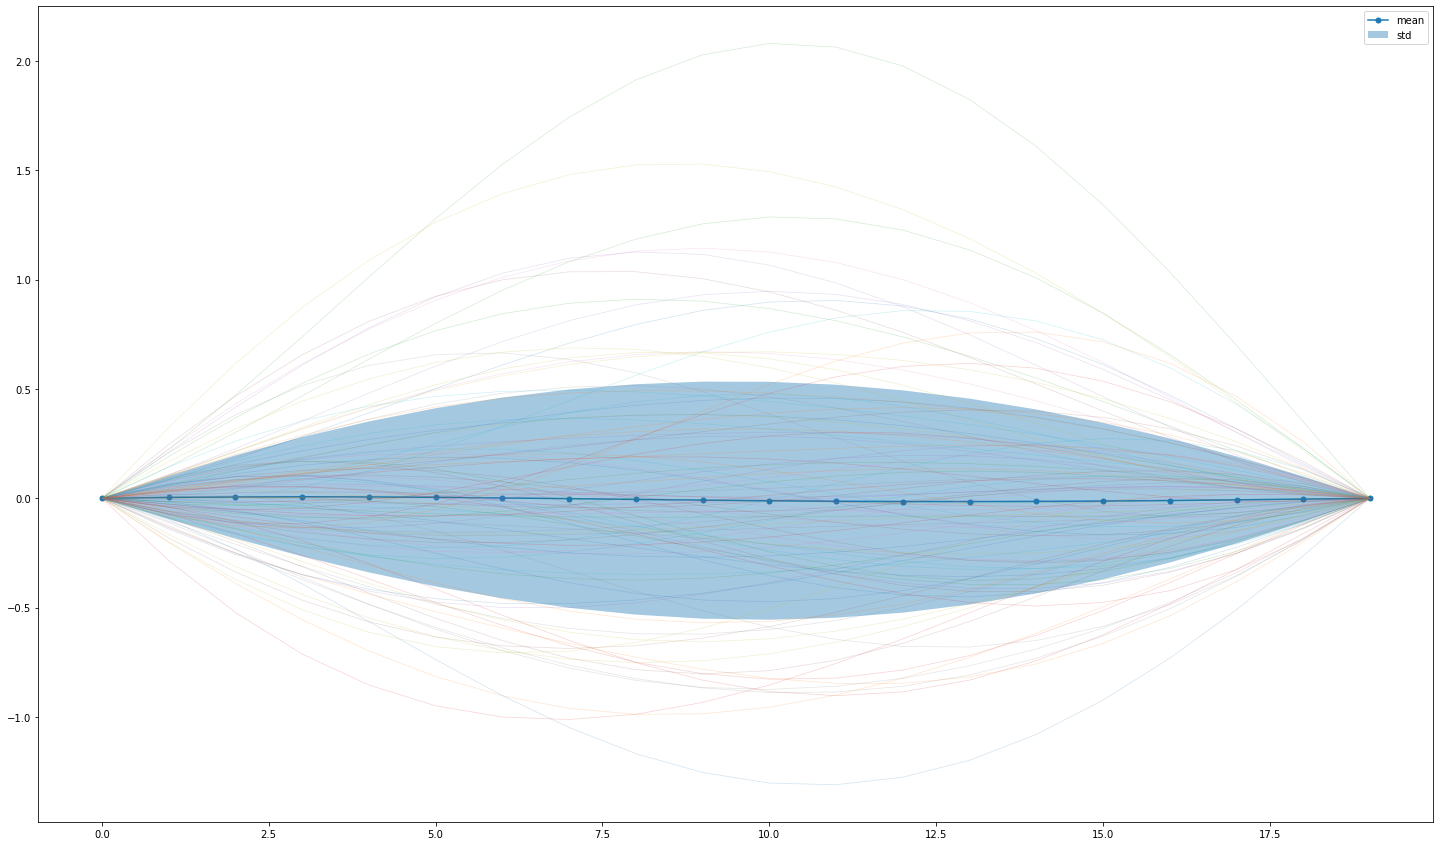

In [51]:
# In the previous code, we made one set of points four times in a loop
# Here, we generate 500 sets of our data points in one go
rvs = multivariate_normal.rvs(cov=cov, size=500)

# Set the start and end points the same for all realisations
rvs -= np.linspace(rvs[:, 0], rvs[:, -1], x.size).T

# Get the mean and std of our 500 realisations
mean = rvs.mean(axis=0)
std = np.std(rvs, axis=0)

# Plot the mean and std
plt.figure(figsize=(25, 15))
plt.plot(x, mean, "o-", ms=5, label="mean")
plt.fill_between(x, mean + std, mean - std, alpha=0.4, label="std")

# And for fun, lets plot 100 of the data realisations
for i in range(100):
    plt.plot(x, rvs[i, :], ls="-", alpha=0.2, lw=0.7)
plt.legend()

In [ ]:
# Set the start and end points the same for all realisations
rvs -= np.linspace(rvs[:, 0], rvs[:, -1], x.size).T

# Get the mean and std of our 500 realisations
mean = rvs.mean(axis=0)
std = np.std(rvs, axis=0)

# Plot the mean and std
plt.figure(figsize=(25, 15))
plt.plot(x, mean, "o-", ms=5, label="mean")
plt.fill_between(x, mean + std, mean - std, alpha=0.4, label="std")

# And for fun, lets plot 100 of the data realisations
for i in range(100):
    plt.plot(x, rvs[i, :], ls="-", alpha=0.2, lw=0.7)
plt.legend()

# 3. GPyTorch

In [3]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, ard_num_dims=1, lengthscale_constraint=None):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.likelihood = likelihood
        self.dim = ard_num_dims
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=ard_num_dims, lengthscale_constraint=lengthscale_constraint))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def start_training(self, train_x, train_y, num_iter=100):
        self.train()
        self.likelihood.train()

        # Use the adam optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self)

        history = {"loss": [], 
                "lengthscale": [],
                "noise": []}

        for i in tqdm(range(num_iter), desc='Training'):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = self(train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, train_y)

            loss.backward()

            history["loss"].append(loss.item())
            lengthscale = self.covar_module.base_kernel.lengthscale.item() if self.dim == 1 else self.covar_module.base_kernel.lengthscale.mean().cpu().detach()
            history["lengthscale"].append(lengthscale)
            history["noise"].append(self.likelihood.noise.item())

            # print(f'Iter {i+1}/{num_iter} - Loss: {loss.item():.3f}  lengthscale: {self.covar_module.base_kernel.lengthscale.item():.3f}  noise: {self.likelihood.noise.item():.3f}')
            optimizer.step()
            
        self.plot_history(history)

    def plot_history(self, history):
        _, ax = plt.subplots(1, 3, figsize=(20, 5))
        # plot all keys in history on cpu
        for i, key in enumerate(history.keys()):
            ax[i].plot(history[key])
            ax[i].set_title(key)
            ax[i].set_xlabel('Iteration')
            ax[i].set_ylabel(key)

## Tutorial

https://docs.gpytorch.ai/en/v1.6.0/examples/02_Scalable_Exact_GPs/Simple_GP_Regression_CUDA.html#

### 1D

#### Training data

Text(0, 0.5, 'y')

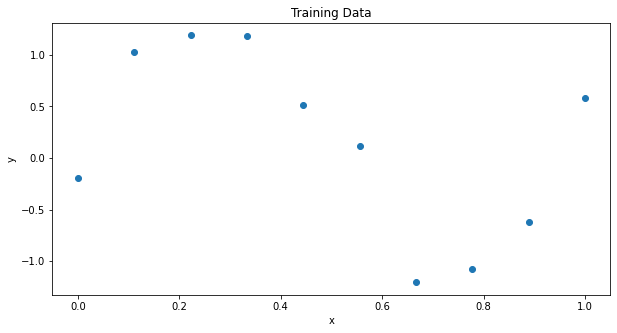

In [88]:
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 10)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * np.pi)) + torch.randn(train_x.size()) * 0.3

# plot the training data
plt.figure(figsize=(10, 5))
plt.plot(train_x.numpy(), train_y.numpy(), 'o')
plt.title('Training Data')
plt.xlabel('x')
plt.ylabel('y')


#### Initialize likelihood and model


In [89]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
train_x = train_x.cuda()
train_y = train_y.cuda()
model = model.cuda()
likelihood = likelihood.cuda()

#### Train model

Training: 100%|██████████| 100/100 [00:00<00:00, 174.38it/s]


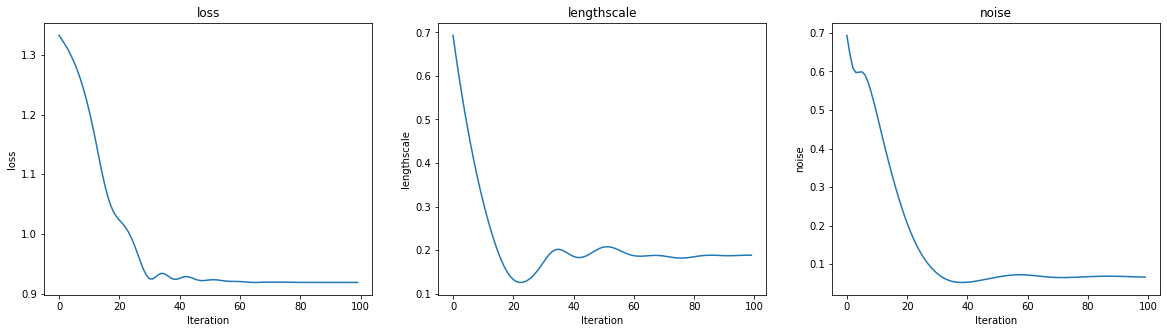

In [90]:
history = model.start_training(train_x, train_y, num_iter=100)

#### Testing

In [91]:
test_x = torch.linspace(0, 1, 51).cuda()

In [92]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

In [93]:
mean = mean.cpu()
lower = lower.cpu()
upper = upper.cpu()

train_x = train_x.cpu()
train_y = train_y.cpu()
test_x = test_x.cpu()

c:\jupyter_workspace\_Diploma\.venv\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


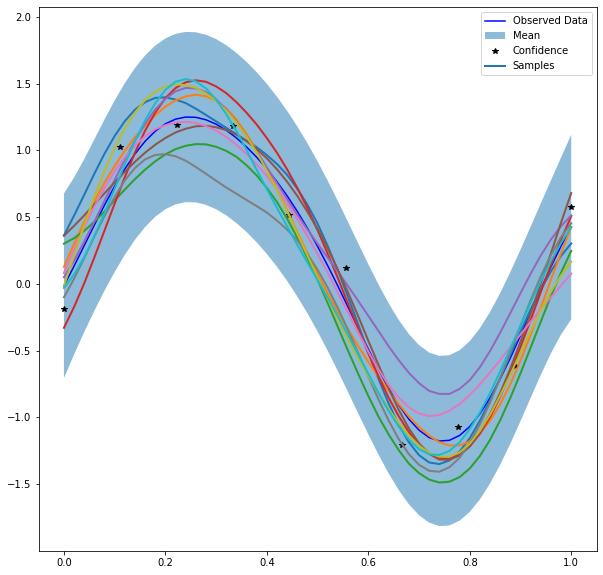

In [94]:
# plot 10 samples from the posterior distribution and real data
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    # ax.set_ylim([-3, 3])
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')

    ax.legend(['Observed Data', 'Mean', 'Confidence'])

    # Get 10 samples from the posterior 
    with gpytorch.settings.fast_pred_var():
        sampled_preds = model(test_x.cuda()).rsample(sample_shape=torch.Size((10,)))
    ax.plot(test_x.cpu().numpy(), sampled_preds.cpu().numpy().T, lw=2)
    # add legend for saamples
    ax.legend(['Observed Data', 'Mean', 'Confidence', 'Samples'])

### My 1D

In [64]:
# Training data is torch tensor [0, 0.05, 0.1, 0.9, 0.95, 1]
train_x = torch.tensor([0, 0.05, 0.1, 0.9, 0.95, 1])
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.zeros_like(train_x)

Text(0, 0.5, 'y')

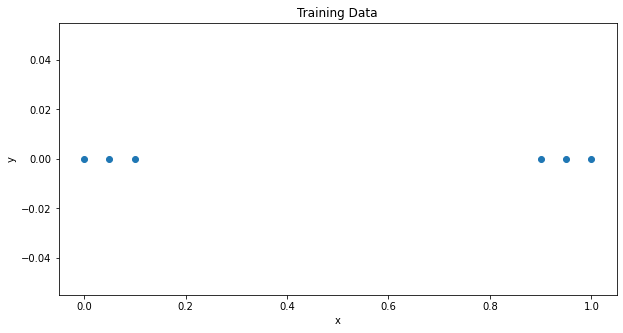

In [73]:
# plot the training data
plt.figure(figsize=(10, 5))
plt.plot(train_x.numpy(), train_y.numpy(), 'o')
plt.title('Training Data')
plt.xlabel('x')
plt.ylabel('y')

In [82]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood, lengthscale_constraint=gpytorch.constraints.Interval(0, 0.2))
train_x = train_x.cuda()
train_y = train_y.cuda()
model = model.cuda()
likelihood = likelihood.cuda()

Training: 100%|██████████| 50/50 [00:00<00:00, 89.55it/s]


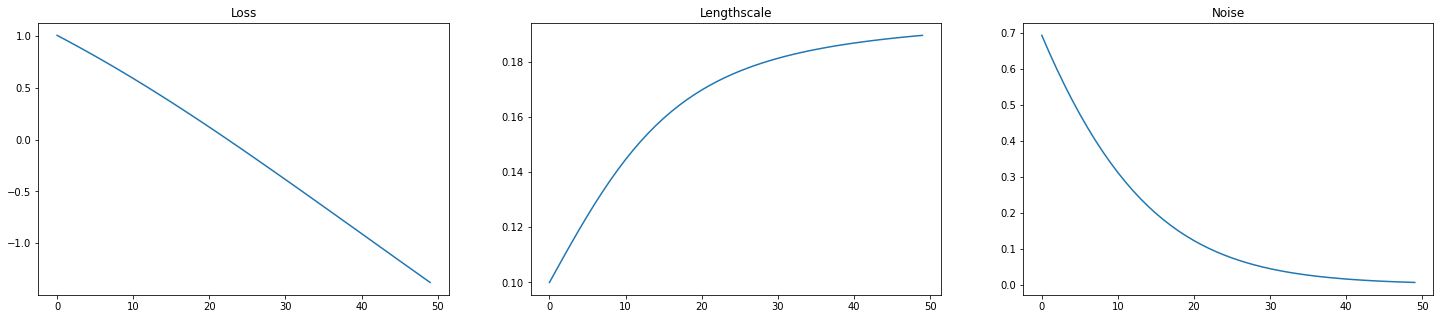

In [83]:
history = model.start_training(train_x, train_y, num_iter=50)

In [84]:
test_x = torch.linspace(0, 1, 51).cuda()

In [85]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

In [86]:
mean = mean.cpu()
lower = lower.cpu()
upper = upper.cpu()

train_x = train_x.cpu()
train_y = train_y.cpu()
test_x = test_x.cpu()

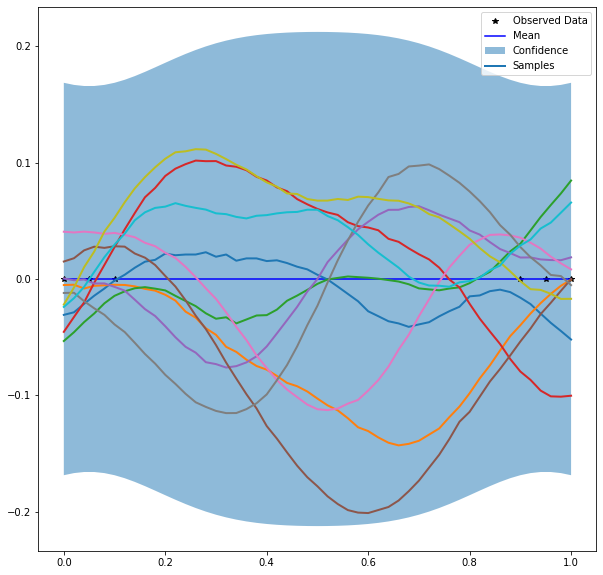

In [87]:
# plot 10 samples from the posterior distribution and real data
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

    # Get 10 samples from the posterior 
    with gpytorch.settings.fast_pred_var():
        sampled_preds = model(test_x.cuda()).rsample(sample_shape=torch.Size((10,)))
    ax.plot(test_x.cpu().numpy(), sampled_preds.cpu().numpy().T, lw=2)
    # add legend for saamples
    ax.legend(['Observed Data', 'Mean', 'Confidence', 'Samples'])

### 2D

In [12]:
def franke(X, Y):
    term1 = .75*torch.exp(-((9*X - 2).pow(2) + (9*Y - 2).pow(2))/4)
    term2 = .75*torch.exp(-((9*X + 1).pow(2))/49 - (9*Y + 1)/10)
    term3 = .5*torch.exp(-((9*X - 7).pow(2) + (9*Y - 3).pow(2))/4)
    term4 = .2*torch.exp(-(9*X - 4).pow(2) - (9*Y - 7).pow(2))
    return term1 + term2 + term3 - term4

In [13]:
xv, yv = torch.meshgrid(torch.linspace(0, 1, 10), torch.linspace(0, 1, 10), indexing="ij")
train_x = torch.cat((
    xv.contiguous().view(xv.numel(), 1),
    yv.contiguous().view(yv.numel(), 1)),
    dim=1
)

f = franke(train_x[:, 0], train_x[:, 1])
train_y = f + torch.randn_like(f)*0.1

In [17]:
class GPModelWithDerivatives(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModelWithDerivatives, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=2)
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModelWithDerivatives(train_x, train_y, likelihood)

In [18]:
train_x = train_x.to(device)
train_y = train_y.to(device)
model = model.to(device)
likelihood = likelihood.to(device)

print(train_x.shape, train_y.shape)

torch.Size([100, 2]) torch.Size([100])


In [19]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
training_iter = 50
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print("Iter %d/%d - Loss: %.3f   lengthscales: %.3f, %.3f   noise: %.3f" % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.squeeze()[0],
        model.covar_module.base_kernel.lengthscale.squeeze()[1],
        model.likelihood.noise.item()
    ))

    optimizer.step()

Iter 1/50 - Loss: 0.819   lengthscales: 0.693, 0.693   noise: 0.693
Iter 2/50 - Loss: 0.799   lengthscales: 0.718, 0.718   noise: 0.669
Iter 3/50 - Loss: 0.780   lengthscales: 0.744, 0.744   noise: 0.644
Iter 4/50 - Loss: 0.761   lengthscales: 0.771, 0.771   noise: 0.621
Iter 5/50 - Loss: 0.742   lengthscales: 0.798, 0.797   noise: 0.598
Iter 6/50 - Loss: 0.723   lengthscales: 0.825, 0.824   noise: 0.576
Iter 7/50 - Loss: 0.704   lengthscales: 0.852, 0.852   noise: 0.554
Iter 8/50 - Loss: 0.685   lengthscales: 0.880, 0.879   noise: 0.533
Iter 9/50 - Loss: 0.666   lengthscales: 0.908, 0.906   noise: 0.513
Iter 10/50 - Loss: 0.647   lengthscales: 0.936, 0.933   noise: 0.493
Iter 11/50 - Loss: 0.627   lengthscales: 0.964, 0.960   noise: 0.474
Iter 12/50 - Loss: 0.608   lengthscales: 0.992, 0.987   noise: 0.455
Iter 13/50 - Loss: 0.589   lengthscales: 1.020, 1.012   noise: 0.437
Iter 14/50 - Loss: 0.569   lengthscales: 1.047, 1.038   noise: 0.419
Iter 15/50 - Loss: 0.550   lengthscales: 1.

Text(0.5, 1.0, 'Predicted values')

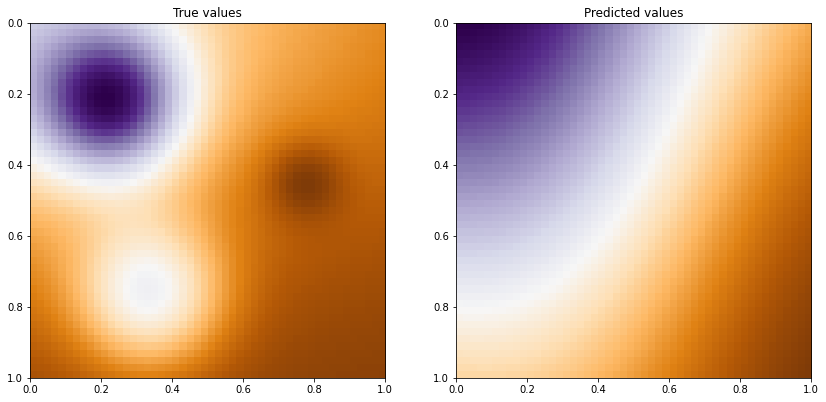

In [20]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
fig, ax = plt.subplots(1, 2, figsize=(14, 10))

# Test points
n1, n2 = 50, 50
xv, yv = torch.meshgrid(torch.linspace(0, 1, n1), torch.linspace(0, 1, n2), indexing="ij")
f = franke(xv, yv)

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_computations(log_prob=False, covar_root_decomposition=False):
    test_x = torch.stack([xv.reshape(n1*n2, 1), yv.reshape(n1*n2, 1)], -1).squeeze(1)
    predictions = likelihood(model(test_x.to(device)))
    mean = predictions.mean

extent = (xv.min(), xv.max(), yv.max(), yv.min())
ax[0].imshow(f, extent=extent, cmap='PuOr')
ax[0].set_title('True values')

ax[1].imshow(mean.cpu().detach().numpy().reshape(n1, n2), extent=extent, cmap='PuOr')
ax[1].set_title('Predicted values')


## My 2D 

#### Training data

In [4]:
xv, yv = torch.meshgrid(torch.linspace(0, 1, IMG_SIZE[0]), torch.linspace(0, 1, IMG_SIZE[1]), indexing="ij")
x_test = torch.cat((
    xv.contiguous().view(xv.numel(), 1),
    yv.contiguous().view(yv.numel(), 1)),
    dim=1)
    
x_train = torch.cat((x_test[:5*100, :], x_test[-5*100:, :]), 0)
y_train = torch.ones(2*5*100)

print(x_train.shape, y_train.shape)
x_train

torch.Size([1000, 2]) torch.Size([1000])


tensor([[0.0000, 0.0000],
        [0.0000, 0.0101],
        [0.0000, 0.0202],
        ...,
        [1.0000, 0.9798],
        [1.0000, 0.9899],
        [1.0000, 1.0000]])

#### Train model

In [5]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train, y_train, likelihood, ard_num_dims=2, lengthscale_constraint=gpytorch.constraints.Interval(0, 0.05))
# put all on GPU
model = model.to(device)
likelihood = likelihood.to(device)
x_train = x_train.to(device)
y_train = y_train.to(device)

Training: 100%|██████████| 50/50 [00:02<00:00, 18.68it/s]


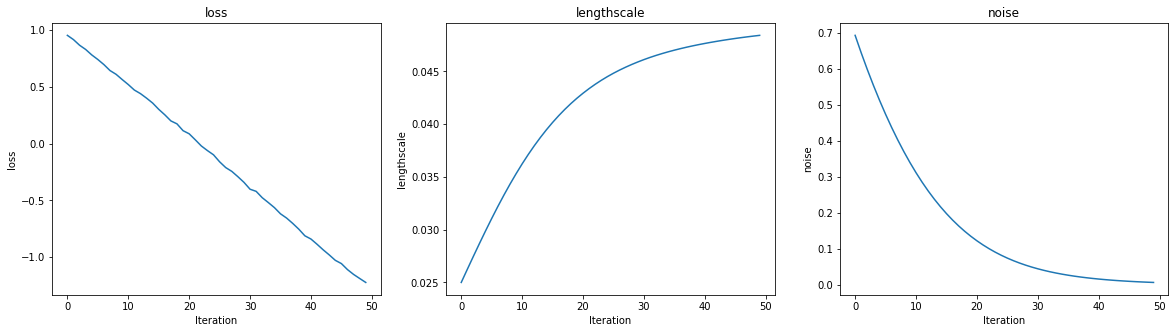

In [6]:
model.start_training(x_train, y_train, num_iter=50)

#### Testing


In [7]:
# plot the results on test set
model.eval()
likelihood.eval()

x, y = torch.meshgrid(torch.linspace(0, 1, IMG_SIZE[0]), torch.linspace(0, 1, IMG_SIZE[1]), indexing="ij")
x_test = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1)), 1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    sampled_preds = model(x_test.cuda()).rsample(sample_shape=torch.Size((5,)))

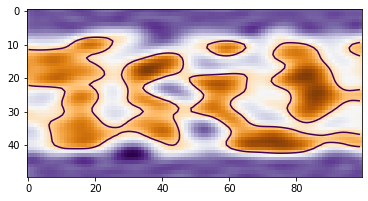

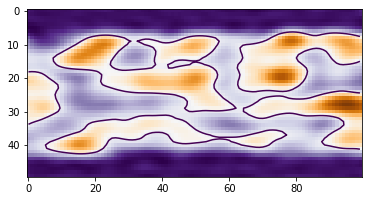

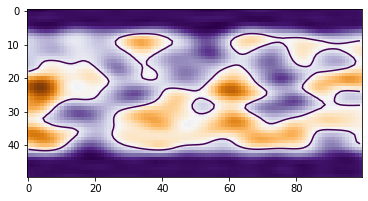

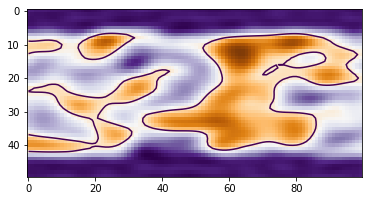

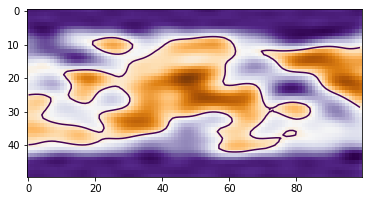

In [8]:
for sample in sampled_preds:
    plt.imshow(sample.cpu().detach().numpy().reshape(IMG_SIZE), cmap='PuOr')
    plt.contour(sample.cpu().detach().numpy().reshape(IMG_SIZE), levels=[0.01])
    plt.show()

## My 3D

In [49]:
def map_to_cylinder(points):
    return torch.stack((torch.cos(2 * torch.pi * points[:, 1]), torch.sin(2 * torch.pi * points[:, 1]), points[:, 0]), -1)

In [59]:
xv, yv = torch.meshgrid(torch.linspace(0, 1, IMG_SIZE[0]), torch.linspace(0, 1, IMG_SIZE[1]), indexing="ij")
x_test = torch.cat((
    xv.contiguous().view(xv.numel(), 1),
    yv.contiguous().view(yv.numel(), 1)),
    dim=1)

x_train = torch.cat((x_test[:5*IMG_SIZE[1], :], x_test[-5*IMG_SIZE[1]:, :]), 0)

x_train = map_to_cylinder(x_train)
x_test = map_to_cylinder(x_test)
y_train = torch.ones(2*5*IMG_SIZE[1])

print(x_train.shape, y_train.shape, x_test.shape)

torch.Size([1000, 3]) torch.Size([1000]) torch.Size([5000, 3])


In [51]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train, y_train, likelihood, ard_num_dims=3, lengthscale_constraint=gpytorch.constraints.Interval(0, 0.1))
# put all on GPU
model = model.to(device)
x_train = x_train.to(device)
y_train = y_train.to(device)

Training: 100%|██████████| 50/50 [00:01<00:00, 36.09it/s]


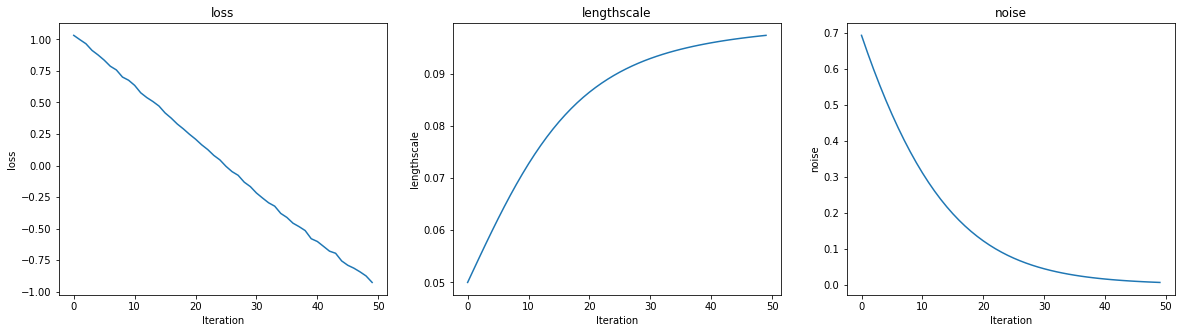

In [52]:
model.start_training(x_train, y_train, num_iter=50)

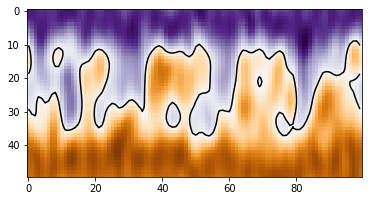

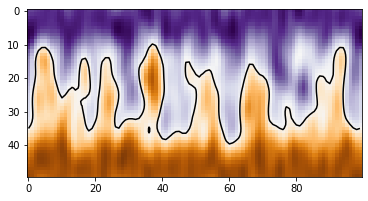

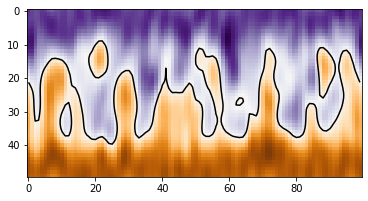

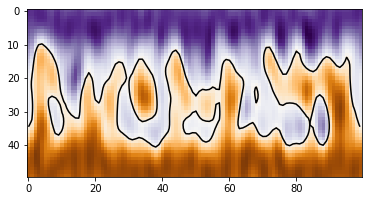

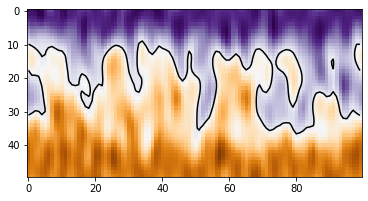

In [53]:
# plot the results on test set
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    sampled_preds = model(x_test.cuda()).rsample(sample_shape=torch.Size((5,)))

for sample in sampled_preds:
    plt.imshow(sample.cpu().detach().numpy().reshape(IMG_SIZE), cmap='PuOr')
    plt.contour(sample.cpu().detach().numpy().reshape(IMG_SIZE), levels=0, colors='k')
    plt.show()

# Other

In [11]:
# PLot random gaussian field 2d
from scipy.stats import multivariate_normal
def plot_gaussian_field_2d(mean, cov, n=100):
    x = np.linspace(-1, 1, n)
    y = np.linspace(-1, 1, n)
    X, Y = np.meshgrid(x, y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    rv = multivariate_normal(mean, cov)
    plt.contourf(X, Y, rv.pdf(pos))
    plt.colorbar()
    plt.show()

In [ ]:
@interact(mean1=(-1, 1, 0.01), mean2=(-1, 1, 0.01), cov11=(0, 1, 0.01), cov12=(-1, 1, 0.01), cov21=(-1, 1, 0.01), cov22=(0, 1, 0.01))
def plot_gaussian_field(mean1=0, mean2=0, cov11=1, cov12=0, cov21=0, cov22=1):
    mean = np.array([mean1, mean2])
    cov = np.array([[cov11, cov12], [cov21, cov22]])
    plot_gaussian_field_2d(mean, cov)
    

In [3]:
# plot random surface in plotly

import plotly.graph_objects as go
import numpy as np
d = np.random.randn(10, 10)


In [7]:
fig = go.Figure(data=[go.Surface(z=d)])
fig.show()

In [19]:
def plot_closed_curve(points_number = 10):
    rho = torch.rand(points_number) * torch.logspace(-0.5, -2.5, points_number)
    phi = 2 * torch.pi * torch.rand(points_number)
    t = torch.linspace(0, 2 * torch.pi, 20)
    r = torch.ones(len(t))
    for h in range(points_number):
        r += rho[h] * torch.sin(h * t + phi[h])
    x, y = r * torch.sin(t), r * torch.cos(t)
    plt.figure(figsize=(18, 9))
    plt.subplot(1, 2, 1)
    plt.plot(t, r, t, r, 'x')
    plt.xlabel('t, radians')
    plt.ylabel('r(t)')
    plt.subplot(1, 2, 2)
    plt.plot(x, y, x, y, 'x')
    plt.xlabel('x(t)')
    plt.ylabel('y(t)')


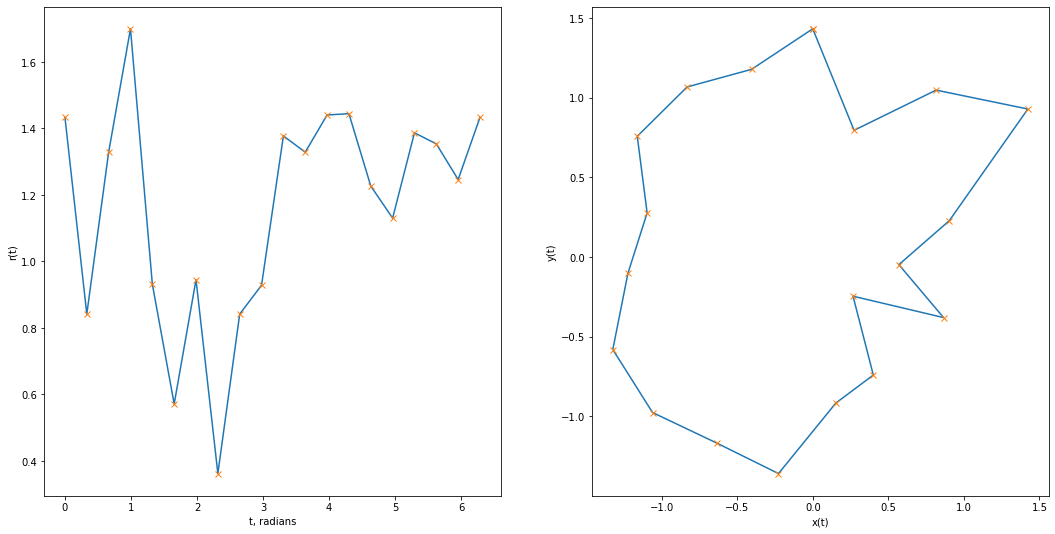

In [20]:
plot_closed_curve(50)

Text(0, 0.5, 'y(t)')

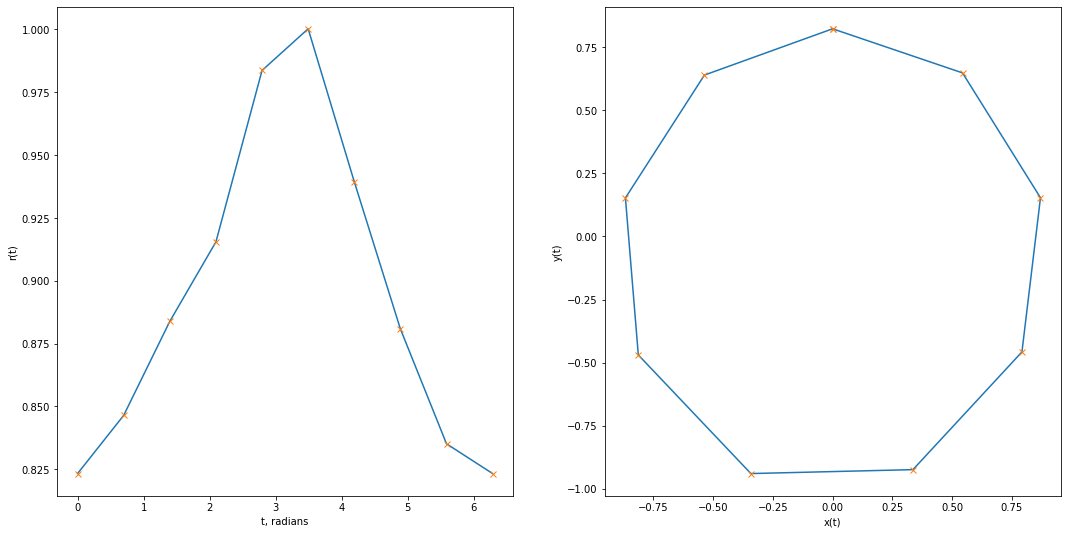

In [21]:
points_number = 5
rho = torch.rand(points_number) * torch.logspace(-0.5, -2.5, points_number)
phi = 2 * torch.pi * torch.rand(points_number)
t = torch.linspace(0, 2 * torch.pi, 10)
r = torch.ones(len(t))
for h in range(points_number):
    r += rho[h] * torch.sin(h * t + phi[h])
x, y = r * torch.sin(t), r * torch.cos(t)
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.plot(t, r, t, r, 'x')
plt.xlabel('t, radians')
plt.ylabel('r(t)')
plt.subplot(1, 2, 2)
plt.plot(x, y, x, y, 'x')
plt.xlabel('x(t)')
plt.ylabel('y(t)')

In [22]:
H = 10
rho = np.random.rand(H)*np.logspace(-0.5,-2.5,H)
phi = np.random.rand(H)* 2*np.pi

t = np.linspace(0,2*np.pi,101)
r = np.ones(len(t))
for h in range(H):
    r = r + rho[h]*np.sin(h*t+phi[h])
x = r * np.cos(t)
y = r * np.sin(t)

Text(0, 0.5, 'y(t)')

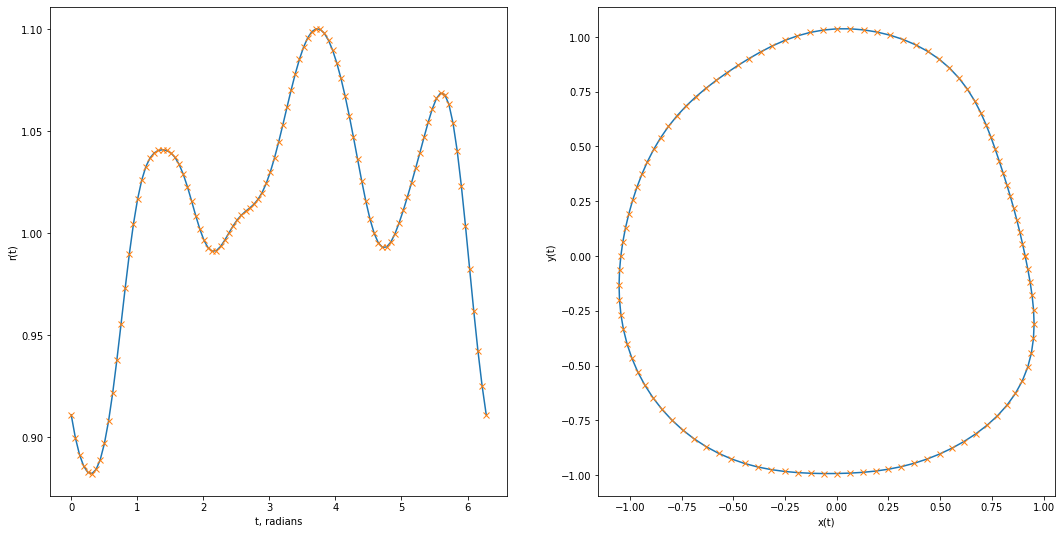

In [23]:
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.plot(t, r, t, r, 'x')
plt.xlabel('t, radians')
plt.ylabel('r(t)')
plt.subplot(1, 2, 2)
plt.plot(x, y, x, y, 'x')
plt.xlabel('x(t)')
plt.ylabel('y(t)')